# 프로젝트 정리  

* 연구 목적
    - 성수동 삐삣버거의 '패티패티' 버거를 미국에서 출시할 때 적정 가격을 예측하는 모델 만들기
* 연구 내용 
    - 성수 삐삣버거의 패티패티 메뉴의 미국에 진출시 적정 가격 예측
    - 메뉴 설명
        - 패티패티
        - 더블패티 + 더블치즈
        - 가격 : 9,500원
* 데이터
    - 미국 내 유명 버거 체인점 9곳의 버거 가격, 영양성분, 브랜드 지수 활용
    - 가정 : 모든 버거의 재료가 같으면 맛은 동일하다.

In [1]:
# 크롤링
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from selenium import webdriver

# 데이터 전처리
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 시각화
from PIL import Image
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 머신러닝 모델

# 머신러닝 모델 평가 모듈

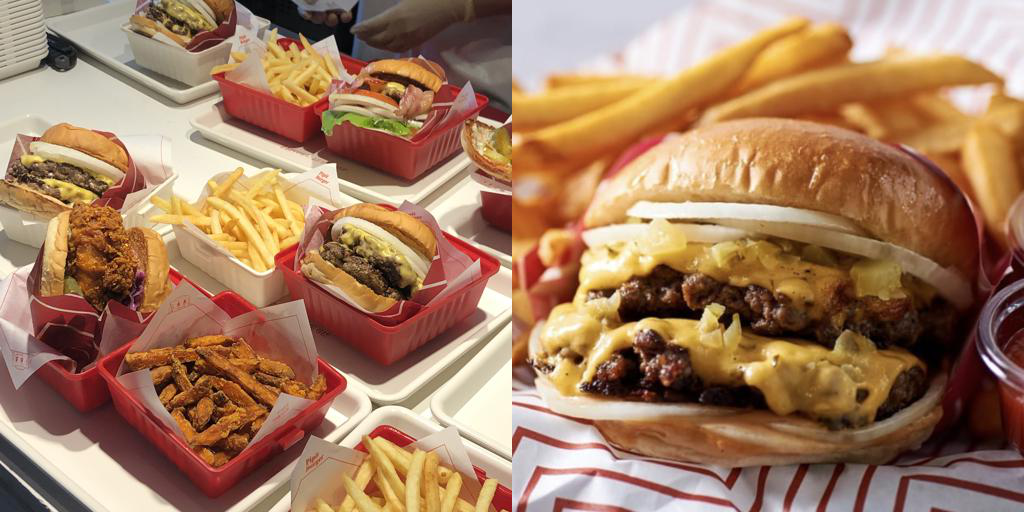

In [2]:
# 삐삣버거 성수점의 메뉴(좌)와 패티패티 버거(우) 이미지 불러오기

image1 = Image.open("./data/pipit1.jpg")
image2 = Image.open("./data/pipit2.jpg")

image1 = image1.resize((512, 512))
image2 = image2.resize((512, 512))

image1_size = image1.size
image2_size = image2.size

new_image = Image.new(
    'RGB', (2*image1_size[0], image1_size[1]), (250, 250, 250))
new_image.paste(image1, (0, 0))
new_image.paste(image2, (image1_size[0], 0))
new_image.save('./data/merged_image.jpg')

image = Image.open("./data/merged_image.jpg")
image

# 데이터 크롤링
- https://www.menuwithprice.com
- 매출 기준 top 9 버거 프랜차이즈의 대표 메뉴 별 가격 및 영양 성분 데이터 크롤링
    - 'inout_burger', 'whataburger', 'hardees', 'habit_burger_grill','Jack in the box', 'McDonald', 'Burgerking', 'carls', 'arbys'
- price data code와 nutrition data code를 통해서 각각 데이터 취합 후 csv로 저장

## Price Data Function

In [3]:
def get_burger_price(brand):

    url = "https://www.menuwithprice.com/menu/{}".format(brand)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, "html.parser")
    elements = dom.select(".tr")

    return [element.text.strip() for element in elements]

In [4]:
def menu_price_split(result):
    ls = []
    for i in result:
        x = i.split("$")
        ls.append(x)
    return ls

## Nutrition Data Function

In [5]:
def get_nutrition(brand, page):
    url = "https://www.menuwithprice.com/nutrition/{}/p/{}".format(brand, page)

    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    driver = webdriver.Chrome(options=options)

    driver.get(url)
    nutritions = driver.find_elements_by_css_selector(
        ".nutri-agen > table > tbody > tr")
    datas = []
    for i in range(1, len(nutritions)):
        title = nutritions[i].find_element_by_css_selector(
            "td:nth-child(1) > a").text
        name = title.split(" ")[:-2]
        name = " ".join(name)
        link = nutritions[i].find_element_by_css_selector(
            "td:nth-child(1) > a").get_attribute("href")
        response = requests.get(link)
        dom = BeautifulSoup(response.content, "html.parser")
        nutrition_fact = dom.select_one(".nutrition > dl > dd > ul").text.replace(
            "\n", "").replace("\'", "").replace("- ", "")
        nutrition_fact = nutrition_fact.split("%")
        calories = nutrition_fact[0]
        fat = nutrition_fact[2]
        carbo = nutrition_fact[6]
        fsp = nutrition_fact[7]

        cal = calories.split('Calories')[2]
        fat = fat.split("Fat")[1].split("g")[0]
        carbo = carbo.split("Carbohydrates")[1].split("g")[0]
        sugar = fsp.split("s")[1].split("P")[0].split("g")[0]
        protein = fsp.split("P")[1].split(" ")[1].split("g")[0]
        serving_size = title.split(" ")[-2:]

        datas.append({
            "menu": name,
            "serving size": serving_size,
            "calories": cal,
            "fat": fat,
            "carbo": carbo,
            "sugar": sugar,
            "protein": protein
        })
    driver.quit()
    return pd.DataFrame(datas)

## 예시 : mcdonald's

In [6]:
# 1. price
'''
brand = "mcdonalds"
mcdonalds_price = get_burger_price(brand)
mcdonalds_price_df = pd.DataFrame(menu_price_split(mcdonalds_price), columns=["menu", "price"])
'''

'\nbrand = "mcdonalds"\nmcdonalds_price = get_burger_price(brand)\nmcdonalds_price_df = pd.DataFrame(menu_price_split(mcdonalds_price), columns=["menu", "price"])\n'

In [7]:
# 2. nutrition fact
'''
mcdonalds1 = get_nutrition("mcdonalds",1)
mcdonalds2 = get_nutrition("mcdonalds",2) 
mcdonalds3 = get_nutrition("mcdonalds",3)
mcdonalds_nutri_df = pd.concat([mcdonalds1, mcdonalds2, mcdonalds3], ignore_index=True)
'''

'\nmcdonalds1 = get_nutrition("mcdonalds",1)\nmcdonalds2 = get_nutrition("mcdonalds",2) \nmcdonalds3 = get_nutrition("mcdonalds",3)\nmcdonalds_nutri_df = pd.concat([mcdonalds1, mcdonalds2, mcdonalds3], ignore_index=True)\n'

In [8]:
# 3. price + nutrition
'''
mcdonalds_total = pd.merge(mcdonalds_price_df, mcdonalds_nutri_df, how="outer")
'''

'\nmcdonalds_total = pd.merge(mcdonalds_price_df, mcdonalds_nutri_df, how="outer")\n'

In [9]:
# 4. to_csv
'''
carls_total.to_csv("mcdonalds.csv")
'''

'\ncarls_total.to_csv("mcdonalds.csv")\n'

# 데이터 전처리

In [10]:
# 미국 프랜차이즈 버거 데이터 불러오기

path = './data'
all_files = glob.glob(path + "/*.csv")

ls = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    ls.append(df)

total_menu = pd.concat(ls, axis=0, ignore_index=True)

# 데이터 전처리

total_menu.drop("Unnamed: 0", axis=1, inplace=True)
total_menu = total_menu.rename({"serving size": "serving_size"}, axis=1)
total_menu

,menu,price,serving_size,calories,fat,carbo,sugar,protein,brand
0,Double-Double Burger,3.45,330,670,41,39,10,37,inout_burger
1,Cheeseburger,2.40,300,330,25,39,7,18,inout_burger
2,Hamburger,2.10,243,390,19,39,10,16,inout_burger
3,Whataburger,3.09,316,590,25,62,12,29,whataburger
4,Double Meat Whataburger,4.59,400,830,44,62,12,47,whataburger
...,...,...,...,...,...,...,...,...,...
150,Jr. Bacon Cheddar Melt,2.09,117,280,12,26,4,16,arbys
151,Chicken Slider,1.49,99,290,12,30,1,15,arbys
152,Corned Beef Slider,1.49,91,220,9,21,1,14,arbys
153,Roast Beef Slider,1.49,91,240,11,21,1,14,arbys


## 파생변수 추가

In [11]:
# 1. 메뉴 이름 길이 컬럼 추가
# 메뉴 이름 길이가 길 수록 가격이 높을 수 있다고 가정
total_menu["menu_length"] = [
    len(total_menu["menu"][i].split(" ")) for i in range(len(total_menu))]

# 2. 빵(bun) 무게 대비 패티, 치즈 무게 컬럼
# 단순히 사이즈가 큰 버거가 아니라 빵은 작지만 패티와 치즈가 많은 버거를 비싼 것으로 가정
total_menu["balance"] = (total_menu["protein"] +
                         total_menu["fat"]) / total_menu["carbo"]

# 3. 가격대별 범위 컬럼 추가
# 가격대별 범위 low(< IQR 25), mid(< median), high(< IQR 75), extra_high(> IQR 75) 로 구분

print('median : ', np.median(total_menu["price"]))
print('하위 25% : ', np.percentile(total_menu["price"], 25))
print('상위 75% : ', np.percentile(total_menu["price"], 75))

idx = total_menu["price"] > 0
total_menu.loc[idx, "price_range"] = "low"
idx2 = total_menu["price"] > np.percentile(total_menu["price"], 25)
total_menu.loc[idx2, "price_range"] = "mid"
idx3 = total_menu["price"] > np.median(total_menu["price"])
total_menu.loc[idx3, "price_range"] = "high"
idx4 = total_menu["price"] > np.percentile(total_menu["price"], 75)
total_menu.loc[idx4, "price_range"] = "extra_high"

# 컬럼 정리
col = ["brand", "menu", "price_range", "price", "serving_size",
       "calories", "fat", "carbo", "sugar", "protein", "menu_length", "balance"]
total_menu = total_menu[col]

# one_hot encoding 으로 price_range 컬럼 활용
total_menu = pd.get_dummies(total_menu, columns=['price_range'])
total_menu

median :  4.49
하위 25% :  3.295
상위 75% :  5.24


,brand,menu,price,serving_size,calories,fat,carbo,sugar,protein,menu_length,balance,price_range_extra_high,price_range_high,price_range_low,price_range_mid
0,inout_burger,Double-Double Burger,3.45,330,670,41,39,10,37,2,2.000000,0,0,0,1
1,inout_burger,Cheeseburger,2.40,300,330,25,39,7,18,1,1.102564,0,0,1,0
2,inout_burger,Hamburger,2.10,243,390,19,39,10,16,1,0.897436,0,0,1,0
3,whataburger,Whataburger,3.09,316,590,25,62,12,29,1,0.870968,0,0,1,0
4,whataburger,Double Meat Whataburger,4.59,400,830,44,62,12,47,3,1.467742,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,arbys,Jr. Bacon Cheddar Melt,2.09,117,280,12,26,4,16,4,1.076923,0,0,1,0
151,arbys,Chicken Slider,1.49,99,290,12,30,1,15,2,0.900000,0,0,1,0
152,arbys,Corned Beef Slider,1.49,91,220,9,21,1,14,3,1.095238,0,0,1,0
153,arbys,Roast Beef Slider,1.49,91,240,11,21,1,14,3,1.190476,0,0,1,0


## 외부데이터 추가
1. 브랜드 파워 지수 입력
    - 브랜드에 따른 가격 변화 추이를 보고자 브랜드 파워 지수 외부데이터
    - 2018년도 미국 내 sales(million dollars), market_share(시장점유율), units(가게수)
    - 참조 사이트 : https://www.qsrmagazine.com/content/qsr-50-burger-segment-1

In [12]:
# 브랜드 지수 데이터 불러오기
brand = pd.read_excel("./data/burger_brand_power.xlsx")
brand.drop("Unnamed: 0", axis=1, inplace=True)

# market_share = 브랜드 별 매출액 / 전체 총 매출액
brand["market_share"] = [d/sum(brand["sales"]) for d in brand['sales']]

# 컬럼명 변경
col = ["brand", "sales", "market_share", "units"]
brand = brand[col]
brand

,brand,sales,market_share,units
0,McDonald,38524.05,0.609808,13914
1,Burgerking,9950.00,0.157501,7327
2,arbys,3886.90,0.061527,3329
3,Jack in the box,3466.13,0.054866,2237
4,whataburger,2416.00,0.038244,825
5,hardees,2120.00,0.033558,1864
6,carls,1425.00,0.022557,1156
7,inout_burger,950.00,0.015038,338
8,habit_burger_grill,436.00,0.006902,247


In [13]:
# total_menu와 외부데이터 brand power 지수 합치기

for i in range(len(total_menu)):
    for j in range(len(brand)):
        if total_menu.loc[i, "brand"] == brand.loc[j, "brand"]:
            total_menu.loc[i, "sales"] = brand.loc[j, "sales"]
            total_menu.loc[i, "market_share"] = brand.loc[j, "market_share"]
            total_menu.loc[i, "units"] = brand.loc[j, "units"]

total_menu

,brand,menu,price,serving_size,calories,fat,carbo,sugar,protein,menu_length,balance,price_range_extra_high,price_range_high,price_range_low,price_range_mid,sales,market_share,units
0,inout_burger,Double-Double Burger,3.45,330,670,41,39,10,37,2,2.000000,0,0,0,1,950.0,0.015038,338.0
1,inout_burger,Cheeseburger,2.40,300,330,25,39,7,18,1,1.102564,0,0,1,0,950.0,0.015038,338.0
2,inout_burger,Hamburger,2.10,243,390,19,39,10,16,1,0.897436,0,0,1,0,950.0,0.015038,338.0
3,whataburger,Whataburger,3.09,316,590,25,62,12,29,1,0.870968,0,0,1,0,2416.0,0.038244,825.0
4,whataburger,Double Meat Whataburger,4.59,400,830,44,62,12,47,3,1.467742,0,1,0,0,2416.0,0.038244,825.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,arbys,Jr. Bacon Cheddar Melt,2.09,117,280,12,26,4,16,4,1.076923,0,0,1,0,3886.9,0.061527,3329.0
151,arbys,Chicken Slider,1.49,99,290,12,30,1,15,2,0.900000,0,0,1,0,3886.9,0.061527,3329.0
152,arbys,Corned Beef Slider,1.49,91,220,9,21,1,14,3,1.095238,0,0,1,0,3886.9,0.061527,3329.0
153,arbys,Roast Beef Slider,1.49,91,240,11,21,1,14,3,1.190476,0,0,1,0,3886.9,0.061527,3329.0


# 데이터 분석

In [14]:
sns.set_palette("Set3")

## 브랜드 별 이상치 확인
- 가격대별, serving_size, calories 이상치 확인
- 결론 : 아웃라이어를 크게 벗어나는 데이터는 없고 데이터 양이 많지 않으므로 이상치를 제거하지 않기로 결정

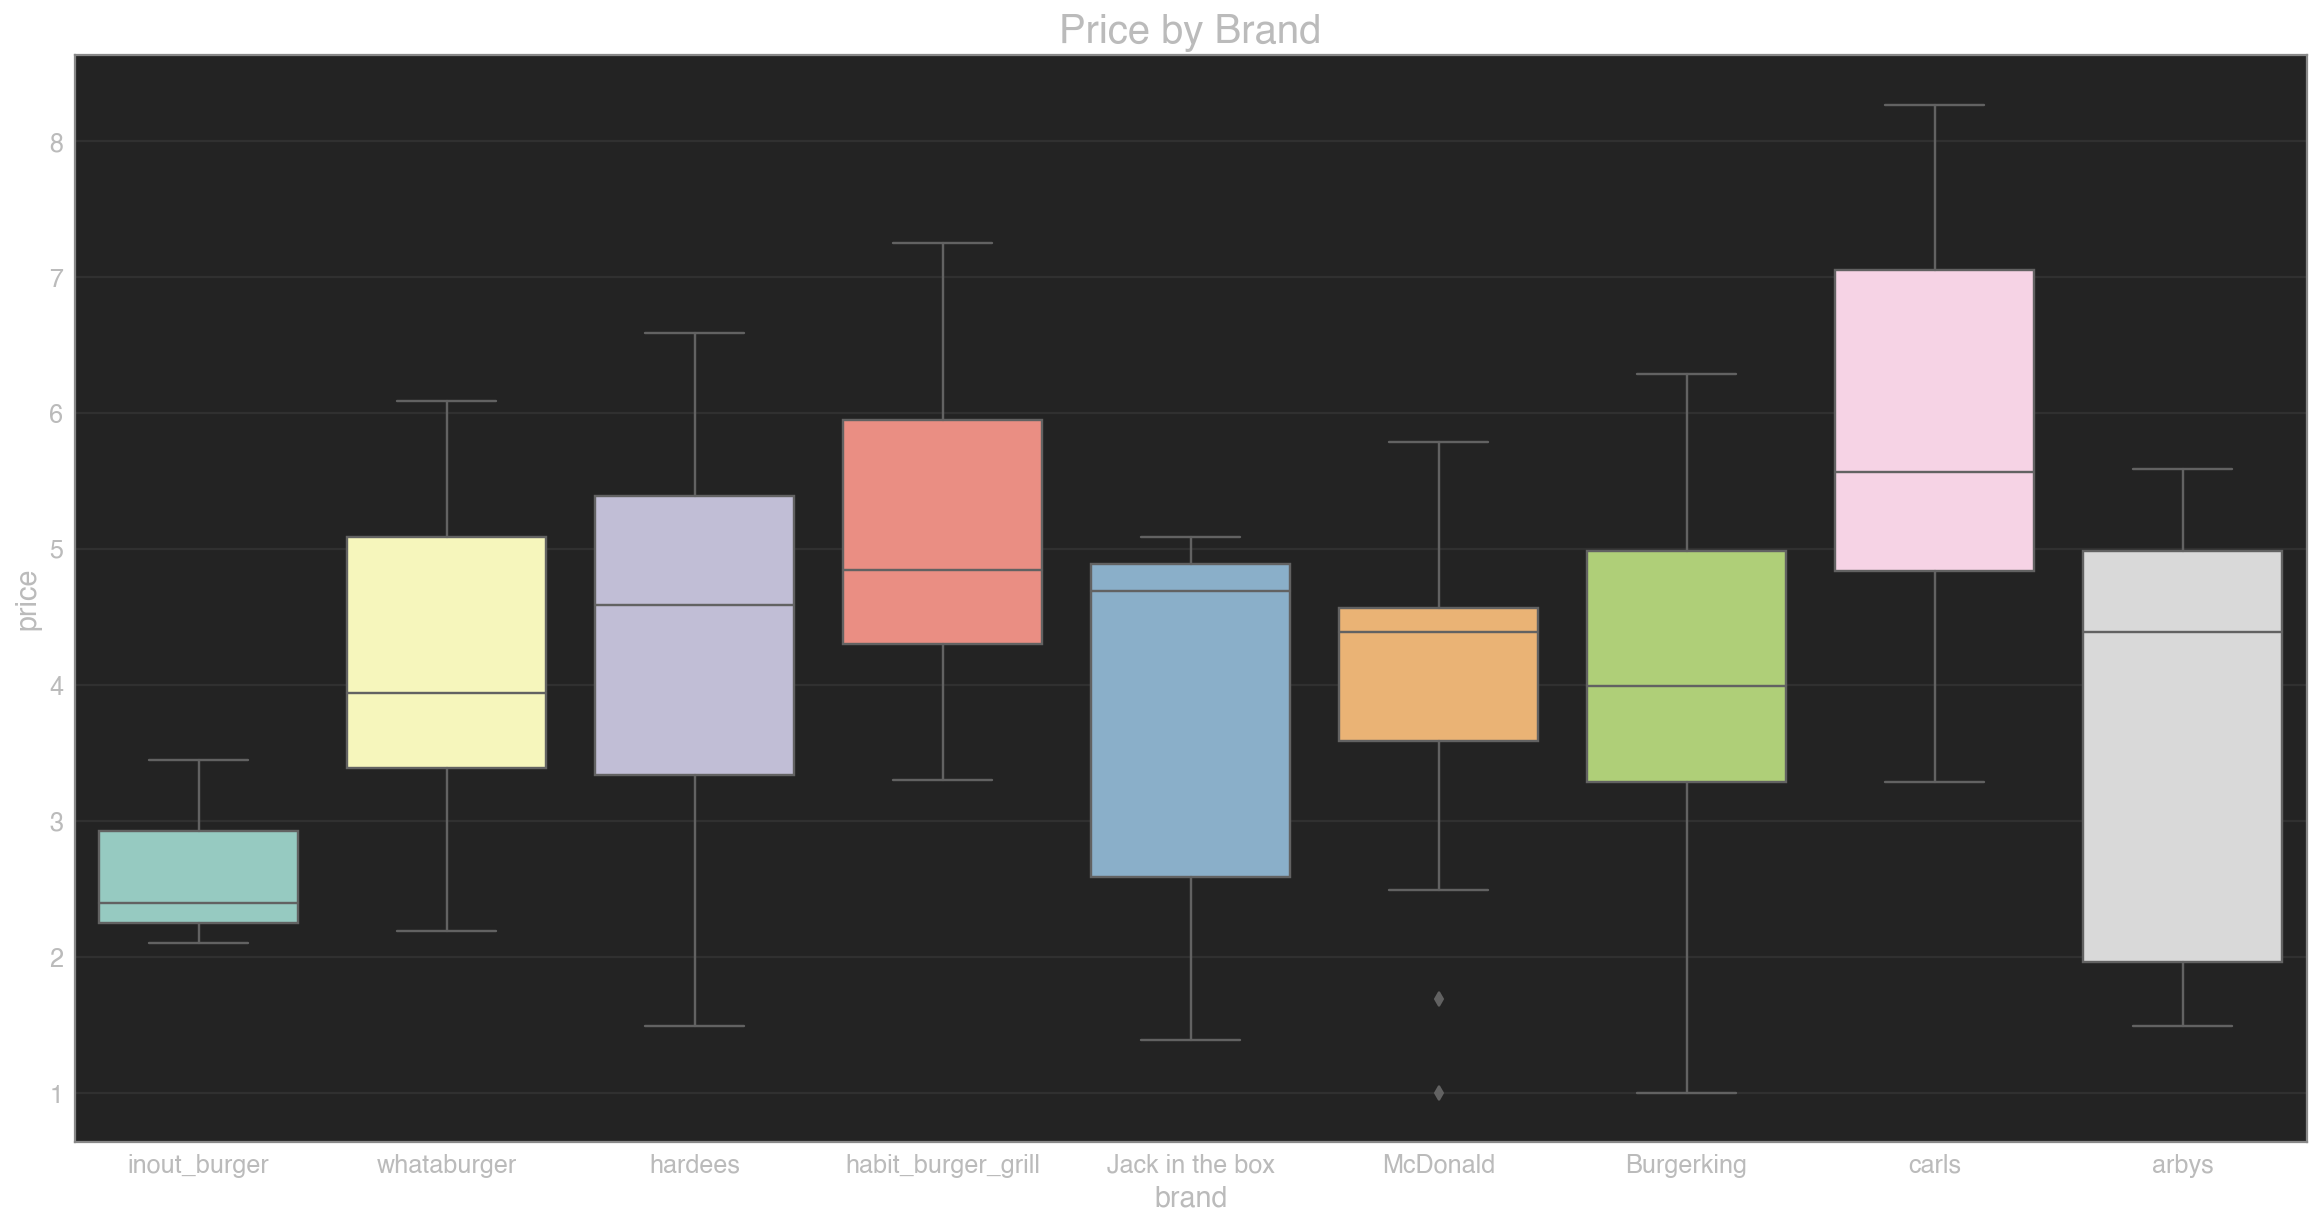

In [15]:
# 브랜드 별 가격군 분석
plt.figure(figsize=(20, 10))
sns.boxplot(x="brand", y="price", data=total_menu)
plt.title("Price by Brand", fontsize=20)
plt.show()

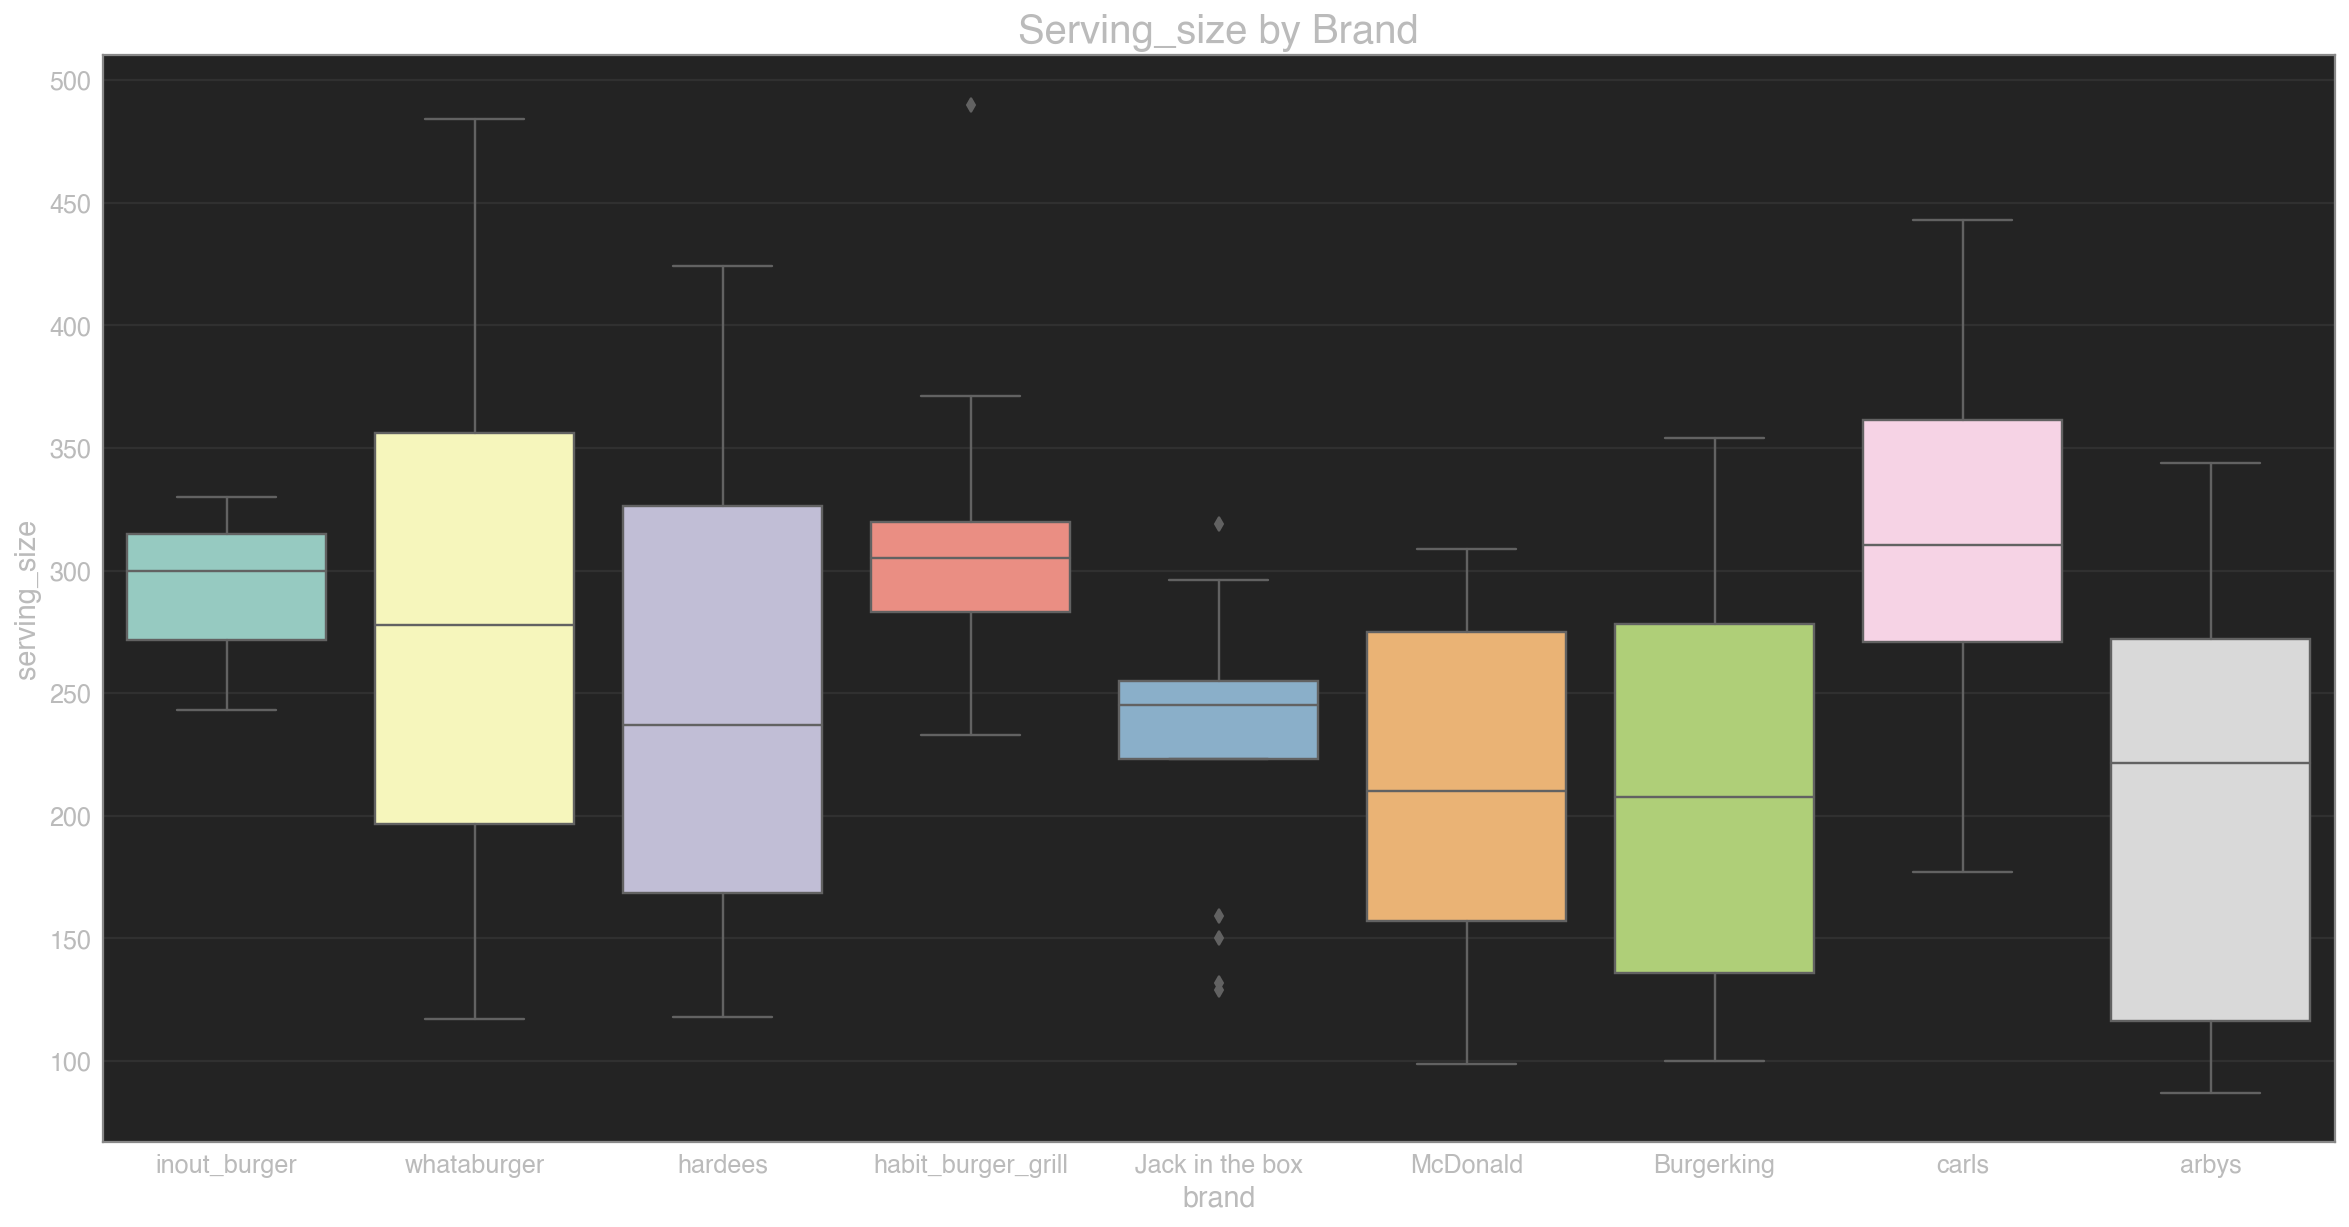

In [16]:
# 브랜드 별 serving_size 분석
plt.figure(figsize=(20, 10))
sns.boxplot(x="brand", y="serving_size", data=total_menu)
plt.title("Serving_size by Brand", fontsize=20)
plt.show()

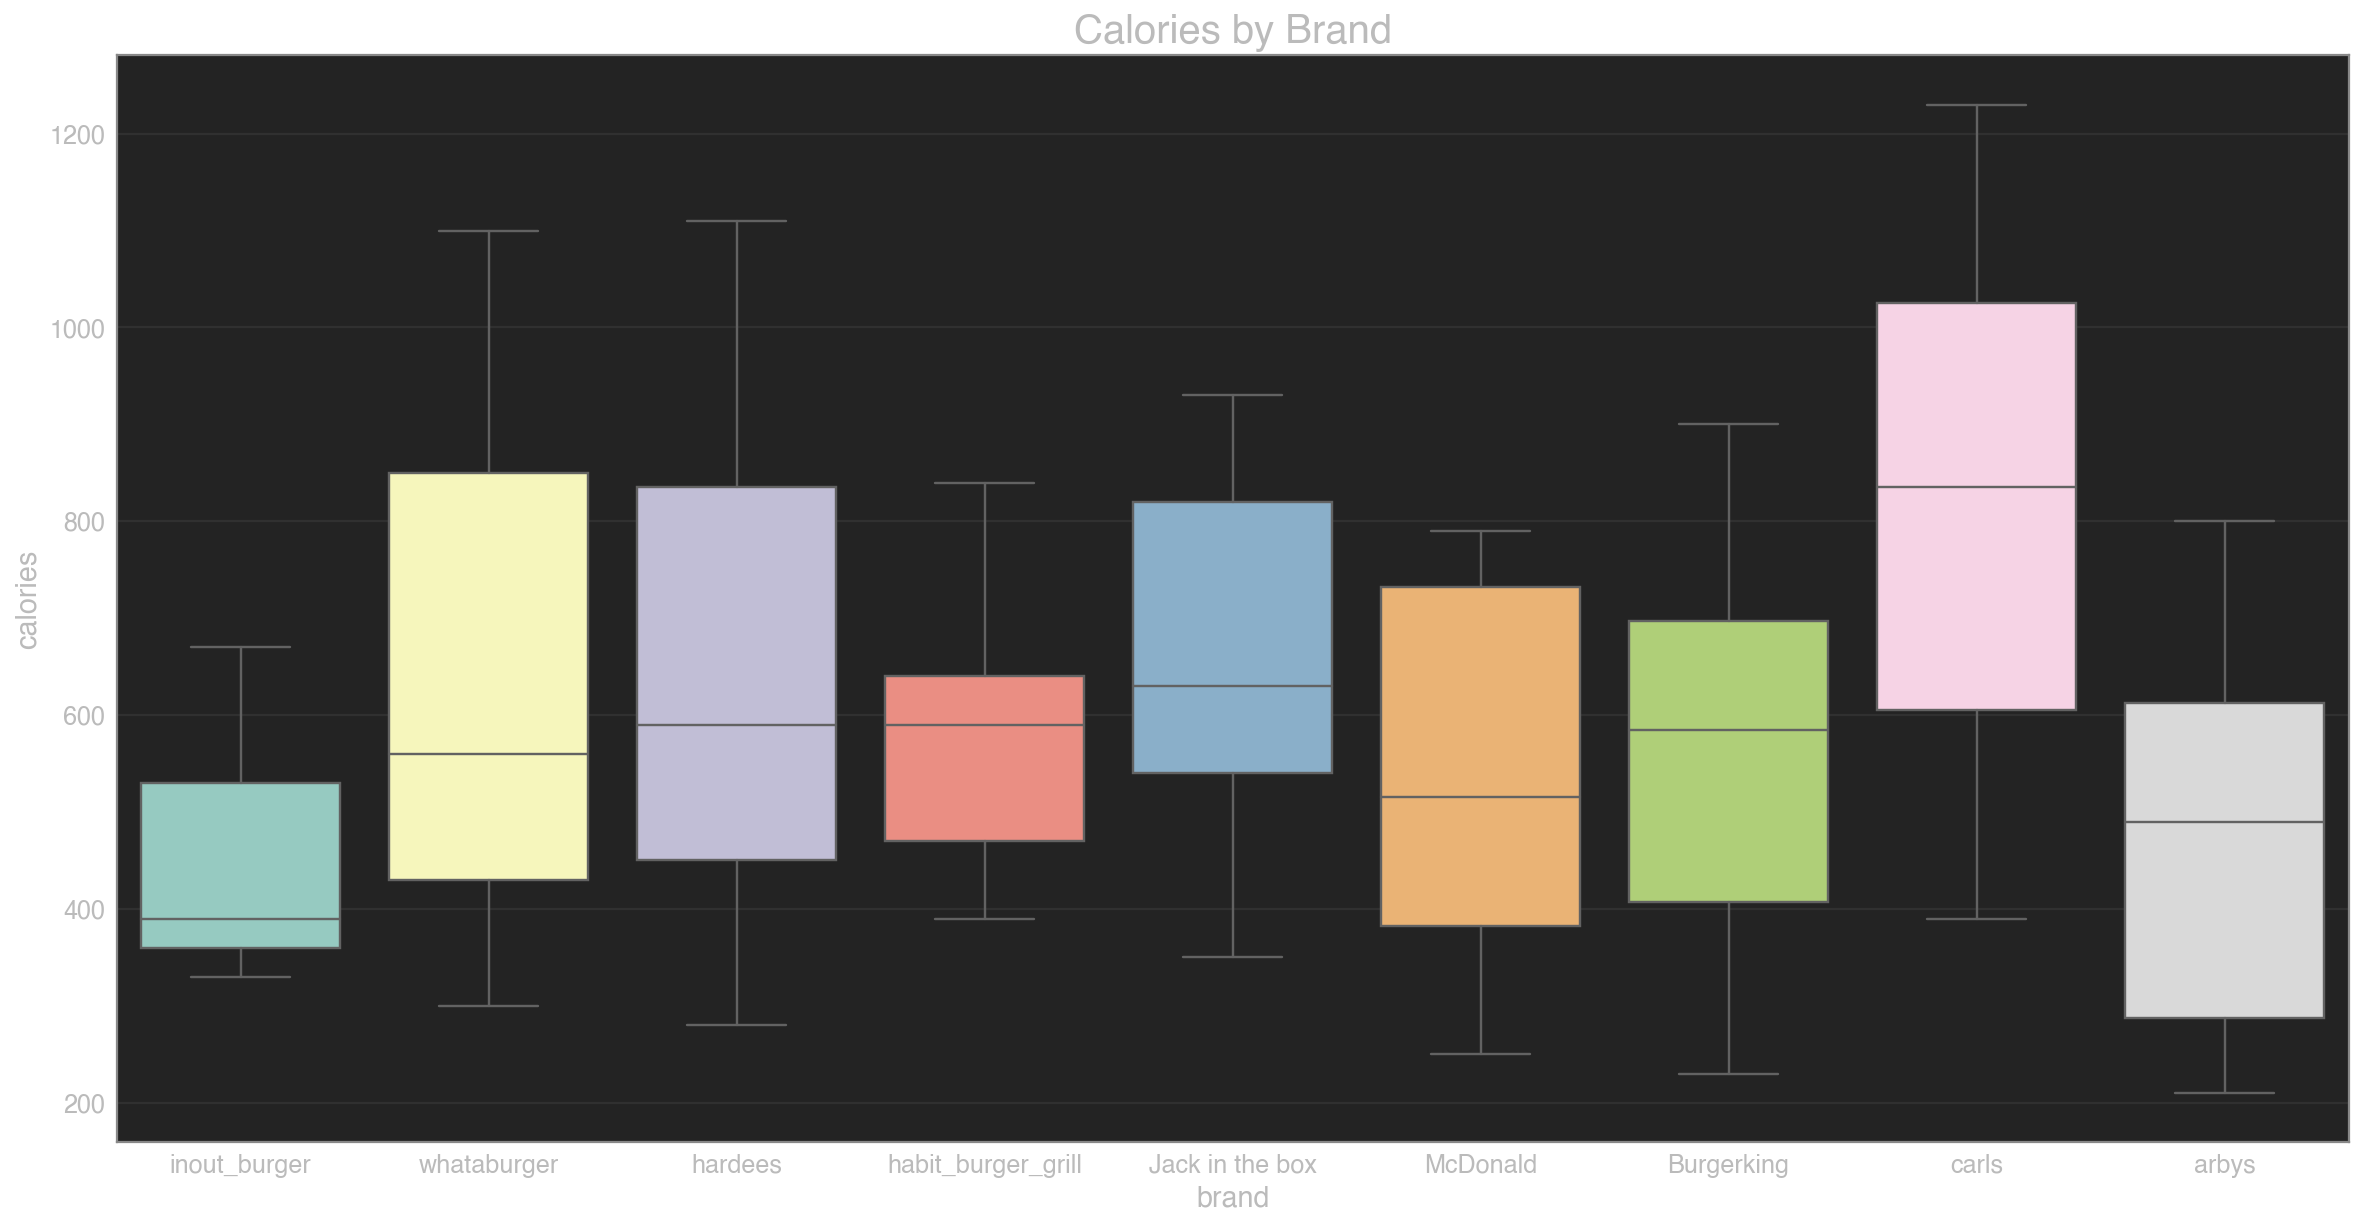

In [17]:
# 브랜드 별 calories 분석
plt.figure(figsize=(20, 10))
sns.boxplot(x="brand", y="calories", data=total_menu)
plt.title("Calories by Brand", fontsize=20)
plt.show()

## 상관관계 분석

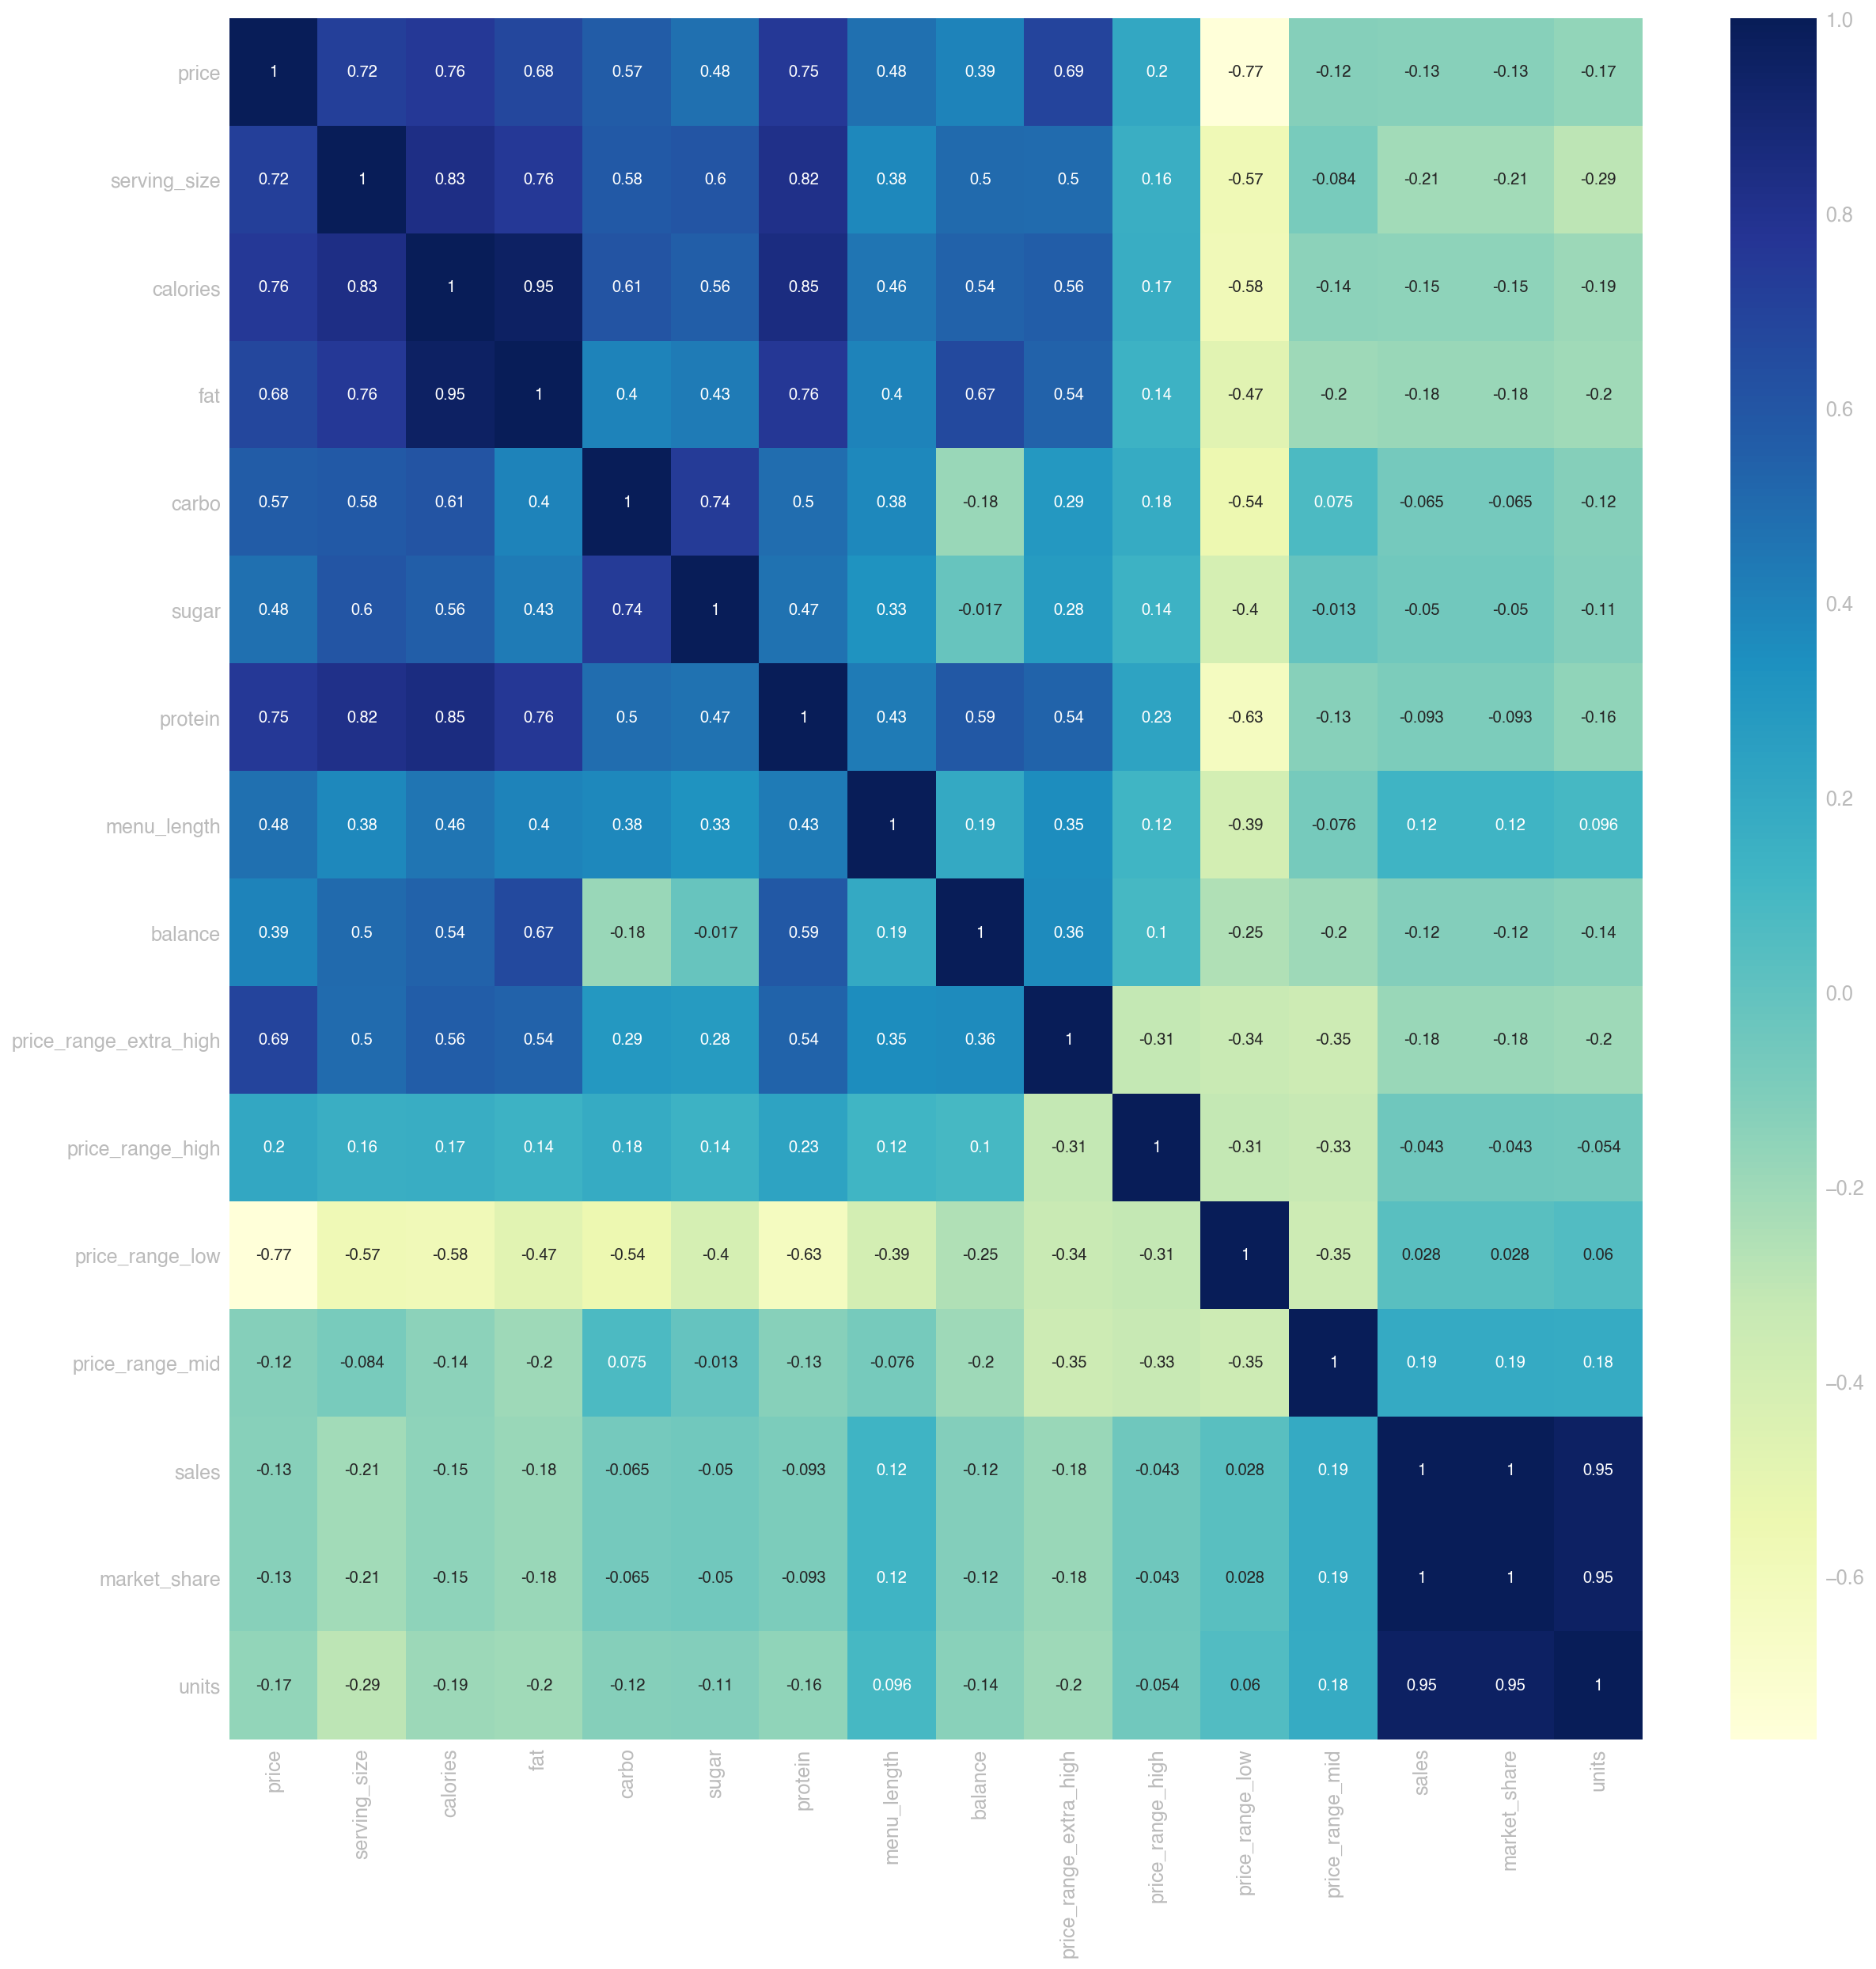

In [18]:
# 상관계수 : spearman 사용(한 변수가 증가할 때 다른 변수가 증가하는지 감소하는지에 대한 관계 설명)
corr = total_menu.corr(method='spearman')

# heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(total_menu.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [19]:
# 가격과 상관관계가 높은 순으로 정렬
corr.loc[:, 'price'].abs().sort_values(ascending=False)[1:]

protein                   0.781324
price_range_low           0.751999
price_range_extra_high    0.751999
calories                  0.746474
serving_size              0.685185
fat                       0.664980
carbo                     0.567323
menu_length               0.503994
balance                   0.501324
sugar                     0.423717
market_share              0.254032
sales                     0.254032
price_range_high          0.253600
price_range_mid           0.238567
units                     0.184488
Name: price, dtype: float64

# 모델링
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- XGBRegressor

In [20]:
# 모델 합치기
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor(
    max_depth=3, random_state=13)))
models.append(('RandomForestRegressor', RandomForestRegressor(
    n_jobs=-1, n_estimators=1000, max_depth=3)))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('XGBRegressor', XGBRegressor(max_depth=2)))

In [21]:
# 모델 학습

# train_test_split
X = total_menu.drop(['price', 'menu', 'brand', 'sales'], axis=1)
y = total_menu['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.2, random_state=13)


r2_score_train = []
r2_score_test = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)

    y_pred_tr = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    r2_score_train.append(r2_score(y_train, y_pred_tr))
    r2_score_test.append(r2_score(y_test, y_pred_test))

r2_score_result = pd.DataFrame({'model name': names,
                                'train score': r2_score_train,
                                'test score': r2_score_test})
r2_score_result

,model name,train score,test score
0,LinearRegression,0.889642,0.709783
1,DecisionTreeRegressor,0.924697,0.871036
2,RandomForestRegressor,0.938127,0.867126
3,GradientBoostingRegressor,0.995415,0.840759
4,XGBRegressor,0.995007,0.785290


In [22]:
r2_score_result[r2_score_result["test score"]
                == max(r2_score_result["test score"])]

,model name,train score,test score
1,DecisionTreeRegressor,0.924697,0.871036


<AxesSubplot:xlabel='price'>

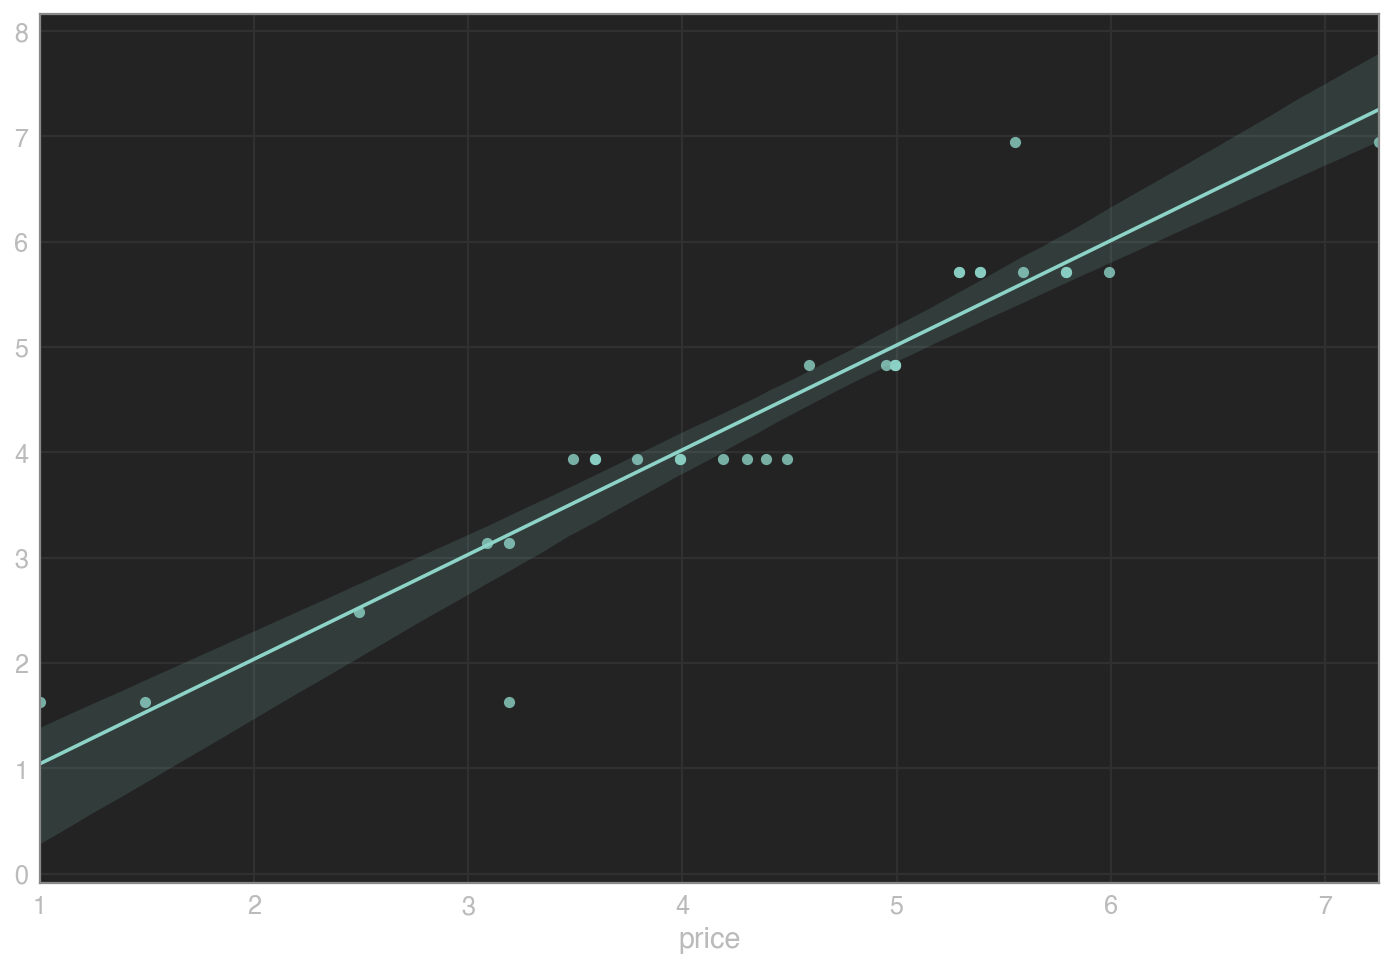

In [23]:
# DecisionTreeRegressor이 test_score 측면에서 가장 높은 성능을 보임
# 예측값과 실제값과의 오차 확인

tree = DecisionTreeRegressor(max_depth=3, random_state=13)
tree.fit(X_train, y_train)
y_pred_test = tree.predict(X_test)

plt.figure(figsize=(12, 8))
sns.regplot(x=y_test, y=y_pred_test, data=y)

## 가격대 별 데이터 균등 분할 후 모델링
- 이전 데이터 모델은 가격대 별로 train_test_split 이 가격군에 쏠림 현상이 있을 수 있다.

### 기존의 가격대별 데이터 비율

In [24]:
# 분할 비율 : X_test 가격대별 데이터 개수 / total_menu 가격대별 데이터 개수

price_range = ["price_range_extra_high_ratio", "price_range_high_ratio",
               "price_range_low_ratio", "price_range_mid_ratio"]

ratio = [round((len(X_test[X_test["price_range_extra_high"] == 1]) / len(total_menu[total_menu["price_range_extra_high"] == 1]))*100, 2),
         round(len(X_test[X_test["price_range_high"] == 1]) /
               len(total_menu[total_menu["price_range_high"] == 1])*100, 2),
         round(len(X_test[X_test["price_range_low"] == 1]) /
               len(total_menu[total_menu["price_range_low"] == 1])*100, 2),
         round(len(X_test[X_test["price_range_mid"] == 1])/len(total_menu[total_menu["price_range_mid"] == 1])*100, 2)]

print(price_range[0], " : ", ratio[0], "%")
print(price_range[1], " : ", ratio[1], "%")
print(price_range[2], " : ", ratio[2], "%")
print(price_range[3], " : ", ratio[3], "%")

price_range_extra_high_ratio  :  25.64 %
price_range_high_ratio  :  14.29 %
price_range_low_ratio  :  15.38 %
price_range_mid_ratio  :  23.81 %


<AxesSubplot:xlabel='range', ylabel='ratio'>

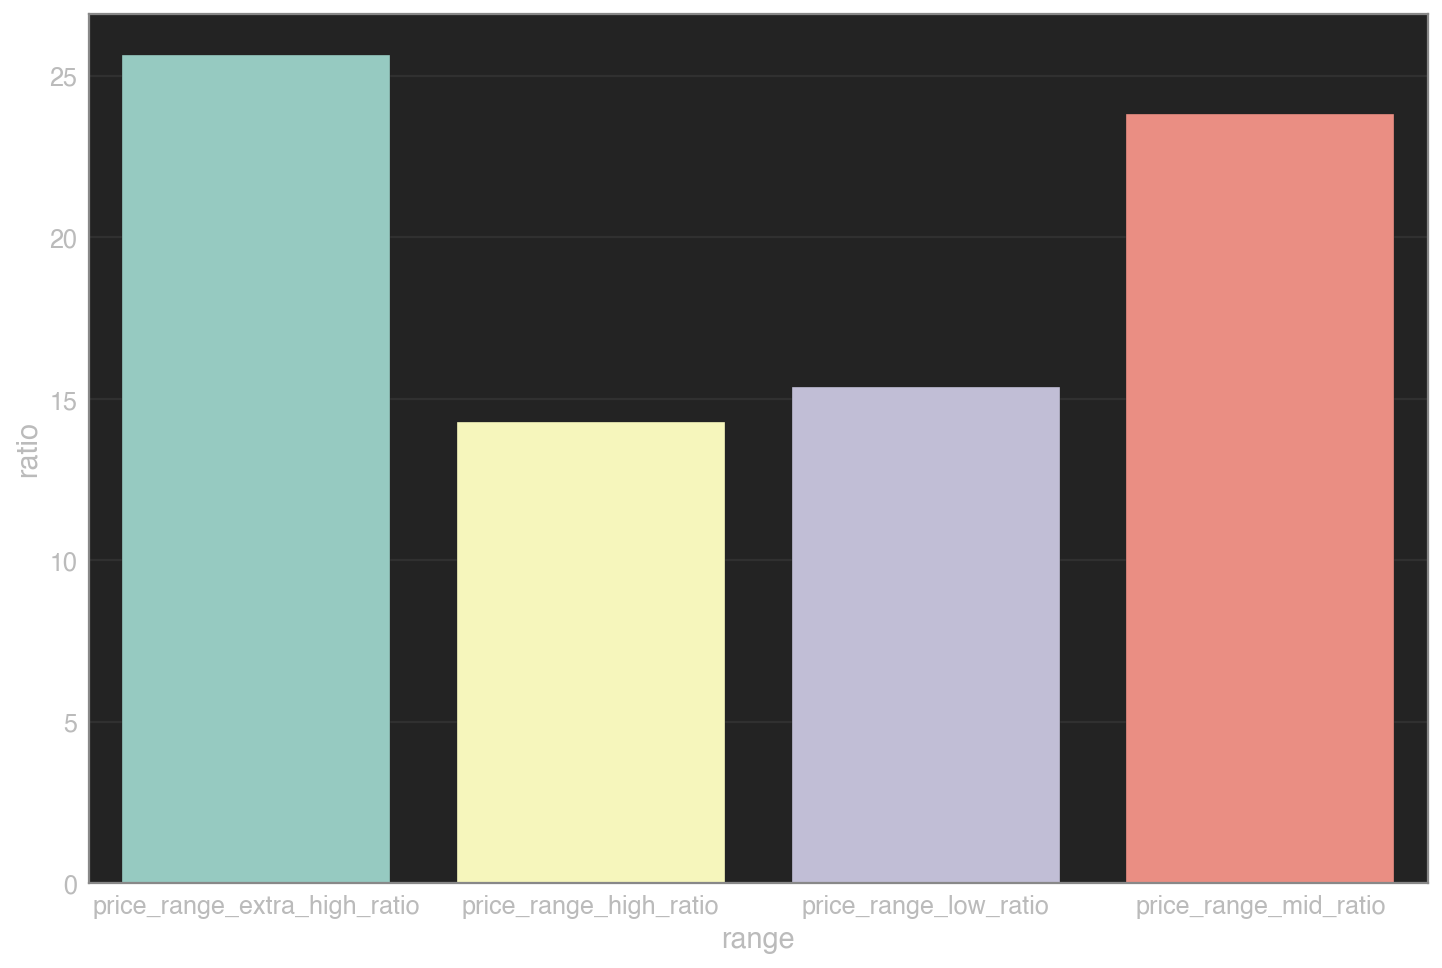

In [25]:
ratio_df = pd.DataFrame({"range": price_range, "ratio": ratio})

plt.figure(figsize=(12, 8))
sns.barplot(x="range", y="ratio", data=ratio_df)

### 가격대별 데이터 균등 분할

In [26]:
# 가격대별 데이터 균등 분할 후 모델링 적용
names = []
r2_score_tr_ls = []
r2_score_test_ls = []

for _ in range(5):
    extra_high = total_menu[total_menu["price_range_extra_high"] == 1]
    high = total_menu[total_menu["price_range_high"] == 1]
    low = total_menu[total_menu["price_range_low"] == 1]
    mid = total_menu[total_menu["price_range_mid"] == 1]

    extra_high = extra_high.sample(frac=1).reset_index(drop=True)
    test_extra_high = extra_high[:round(len(extra_high)*0.2)]
    train_extra_high = extra_high[round(len(extra_high)*0.2):]

    high = high.sample(frac=1).reset_index(drop=True)
    test_high = high[:round(len(high)*0.2)]
    train_high = high[round(len(high)*0.2):]

    low = low.sample(frac=1).reset_index(drop=True)
    test_low = low[:round(len(low)*0.2)]
    train_low = low[round(len(low)*0.2):]

    mid = mid.sample(frac=1).reset_index(drop=True)
    test_mid = mid[:round(len(mid)*0.2)]
    train_mid = mid[round(len(mid)*0.2):]

    test = test_extra_high.append(
        [test_high, test_low, test_mid], ignore_index=True)
    train = train_extra_high.append(
        [train_high, train_low, train_mid], ignore_index=True)

    X_train = train.drop(['price', 'menu', 'brand', 'sales'], axis=1)
    X_test = test.drop(['price', 'menu', 'brand', 'sales'], axis=1)
    y_train = train['price']
    y_test = test['price']

    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)

        y_pred_tr = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        names.append(name)
        r2_score_tr_ls.append(r2_score(y_train, y_pred_tr))
        r2_score_test_ls.append(r2_score(y_test, y_pred_test))

        result = pd.DataFrame({'model_name': names,
                               'r2_score_train': r2_score_tr_ls,
                               'r2_score_test': r2_score_test_ls})

In [27]:
# 가격대별 균등 분할 데이터 비율 : X_test 가격대별 데이터 개수 / total_menu 가격대별 데이터 개수
price_range = ["price_range_extra_high_ratio", "price_range_high_ratio",
               "price_range_low_ratio", "price_range_mid_ratio"]
ratio = [round((len(X_test[X_test["price_range_extra_high"] == 1]) / len(total_menu[total_menu["price_range_extra_high"] == 1]))*100, 2),
         round(len(X_test[X_test["price_range_high"] == 1]) /
               len(total_menu[total_menu["price_range_high"] == 1])*100, 2),
         round(len(X_test[X_test["price_range_low"] == 1]) /
               len(total_menu[total_menu["price_range_low"] == 1])*100, 2),
         round(len(X_test[X_test["price_range_mid"] == 1])/len(total_menu[total_menu["price_range_mid"] == 1])*100, 2)]


print(price_range[0], " : ", ratio[0], "%")
print(price_range[1], " : ", ratio[1], "%")
print(price_range[2], " : ", ratio[2], "%")
print(price_range[3], " : ", ratio[3], "%")

price_range_extra_high_ratio  :  20.51 %
price_range_high_ratio  :  20.0 %
price_range_low_ratio  :  20.51 %
price_range_mid_ratio  :  19.05 %


<AxesSubplot:xlabel='range', ylabel='ratio'>

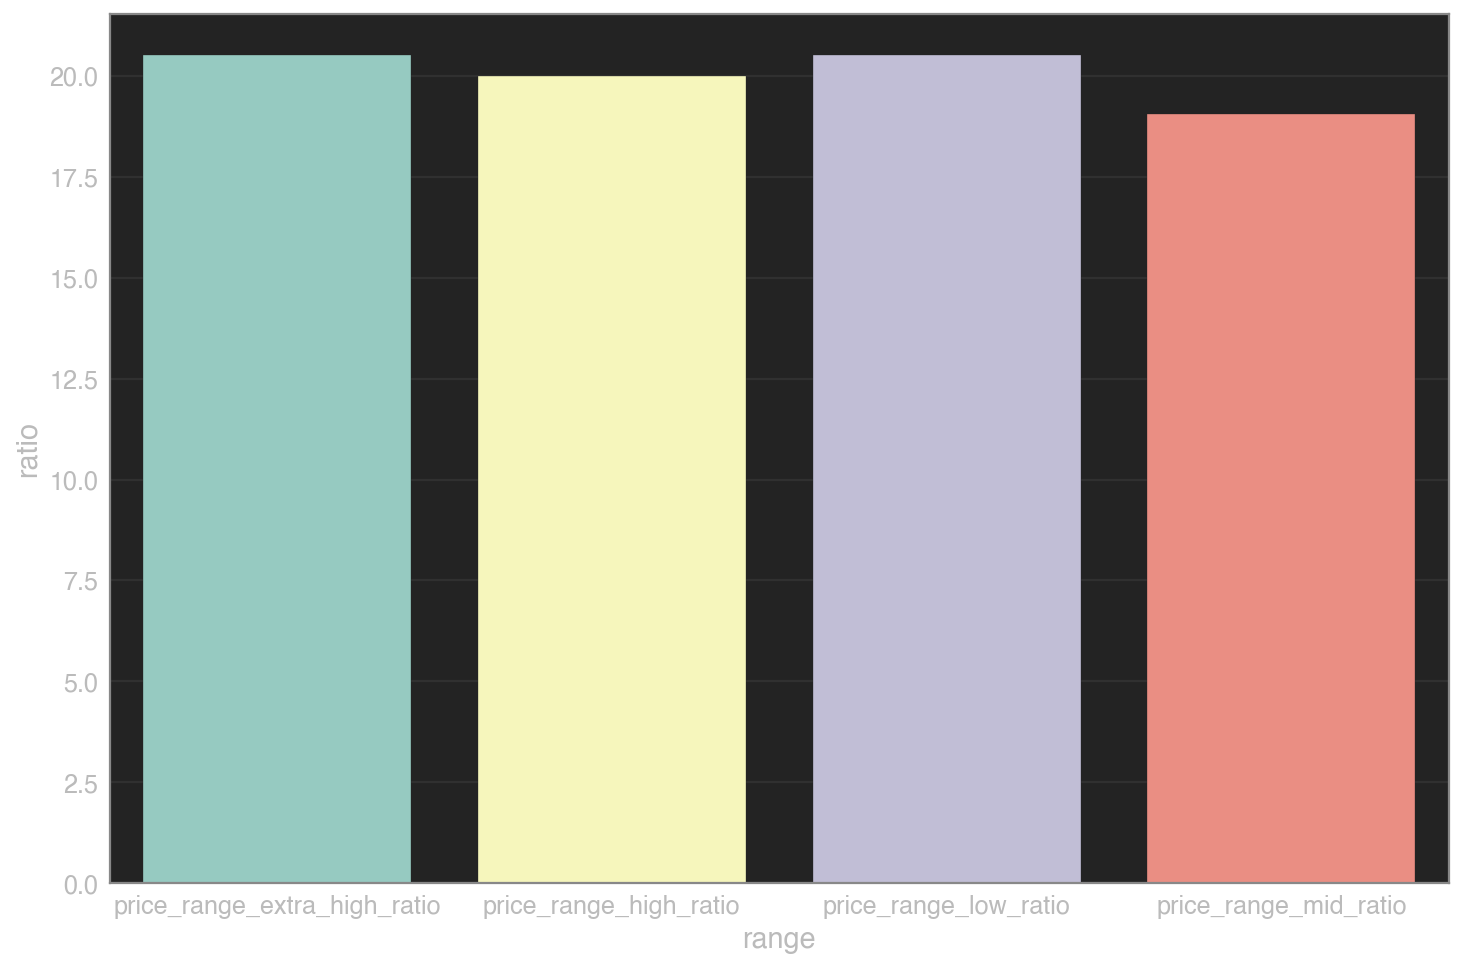

In [28]:
ratio_df = pd.DataFrame({"range": price_range,
                         "ratio": ratio})

plt.figure(figsize=(12, 8))
sns.barplot(x="range", y="ratio", data=ratio_df)

In [29]:
# 5번 랜덤 샘플링을 하여 모델을 돌렸으므로 5번에 대한 mean값으로 최종 모델 검증을 한다.
result

,model_name,r2_score_train,r2_score_test
0,LinearRegression,0.859467,0.882251
1,DecisionTreeRegressor,0.922133,0.878769
2,RandomForestRegressor,0.929402,0.920435
3,GradientBoostingRegressor,0.995041,0.872800
4,XGBRegressor,0.993942,0.874123
5,LinearRegression,0.875603,0.784412
6,DecisionTreeRegressor,0.927608,0.864648
7,RandomForestRegressor,0.941174,0.856645
8,GradientBoostingRegressor,0.993542,0.809236
9,XGBRegressor,0.994559,0.825490


In [30]:
# final_result df 만들기
lr_r2_tr = np.mean(result[result["model_name"] ==
                          'LinearRegression'].loc[:, 'r2_score_train'])
lr_r2_test = np.mean(result[result["model_name"] ==
                            'LinearRegression'].loc[:, 'r2_score_test'])

dt_r2_tr = np.mean(result[result["model_name"] ==
                          'DecisionTreeRegressor'].loc[:, 'r2_score_train'])
dt_r2_test = np.mean(result[result["model_name"] ==
                            'DecisionTreeRegressor'].loc[:, 'r2_score_test'])

rf_r2_tr = np.mean(result[result["model_name"] ==
                          'RandomForestRegressor'].loc[:, 'r2_score_train'])
rf_r2_test = np.mean(result[result["model_name"] ==
                            'RandomForestRegressor'].loc[:, 'r2_score_test'])

gb_r2_tr = np.mean(result[result["model_name"] ==
                          'GradientBoostingRegressor'].loc[:, 'r2_score_train'])
gb_r2_test = np.mean(result[result["model_name"] ==
                            'GradientBoostingRegressor'].loc[:, 'r2_score_test'])

xgb_r2_tr = np.mean(result[result["model_name"] ==
                           'XGBRegressor'].loc[:, 'r2_score_train'])
xgb_r2_test = np.mean(
    result[result["model_name"] == 'XGBRegressor'].loc[:, 'r2_score_test'])

model_names = ['LinearRegression', 'DecisionTreeRegressor',
               'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
r2_tr = [lr_r2_tr, dt_r2_tr, rf_r2_tr, gb_r2_tr, xgb_r2_tr]
r2_test = [lr_r2_test, dt_r2_test, rf_r2_test, gb_r2_test, xgb_r2_test]

final_result = pd.DataFrame({"model_names": model_names,
                             "r2_tr": r2_tr,
                             "r2_test": r2_test,
                             })
final_result

,model_names,r2_tr,r2_test
0,LinearRegression,0.869446,0.834673
1,DecisionTreeRegressor,0.923875,0.881366
2,RandomForestRegressor,0.933101,0.892351
3,GradientBoostingRegressor,0.994621,0.866238
4,XGBRegressor,0.994029,0.866136


In [31]:
# 가격대별 균등 분할한 데이터 셋에서는 r2_test 기준 최고의 성능을 보여주는 모델은 RandomForest Regressor임을 알 수 있다.
final_result[final_result['r2_test'] == max(final_result['r2_test'])]

,model_names,r2_tr,r2_test
2,RandomForestRegressor,0.933101,0.892351


# 결론
- 최종적으로 RandomForest Regressor를 회귀 모델로 활용함
- 성수 삐삣버거 패티패티 햄버거를 가격을 예측하라
- 영양정보 성분 참조 사이트 : https://www.fatsecret.kr/
- 더블 패티, 더블 치즈, 햄버거 번, 소스 20g
    - 패티 : size - 80g / 칼로리 - 209 kcal / protein - 19.83g / fat - 13.72g
    - 치즈 : size - 20g / 칼로리 - 65 kcal / protein - 3.80g / fat - 5.50g
    - 햄버거 번 : size - 60g / 칼로리 - 168 kcal / carbo - 29.77g / protein - 5.71g / fat - 2.6g
    - 소스 : sugar 20g
- 삐삣버거 패티패티의 영양성분 표시
    - serving_size = 280
    - calories = 716
    - protein = 52.97
    - fat = 41.04
    - carbo = 29.77
    - sugar = 20
- 메뉴 이름 : pipit double double burger from seongsu in South Korea
- 삐삣버거 가격 : $ 8.05(환율 1,180원 적용시) - 9,500원

In [32]:
# RandomForestRegressor 모델 학습
reg = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_depth=3)
reg.fit(X_train, y_train)

# 패티패티 버거 정보
serving_size = 280
calories = 716
fat = 41.04
carbo = 29.77
sugar = 20
protein = 52.97
menu_length = 9  # pipit double double burger from seongsu in South Korea
balance = (protein + fat)/carbo
market_share = 0  # 처음 진입하므로 시장점유울 0%
units = 1  # 첫 매장이므로 units = 1
price_range_extra_high = 0
price_range_high = 1  # 한국에서의 삐삣버거의 브랜드 포지션
price_range_low = 0
price_range_mid = 0

my_burger = [[serving_size, calories, carbo, protein, fat, sugar, menu_length, balance,
              market_share, units, price_range_extra_high, price_range_high, price_range_low,
              price_range_mid]]
my_predict = reg.predict(my_burger)
my_predict

array([4.36027389])